### Simple GAN Model with Class

#### Preparation

##### Load the Library

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

tf.__version__         # python=3.9

'2.7.4'

##### Prepare Training Data

In [4]:
# When training the model, the label of the real-image is set to "real(1)".
# (So there is no need to bring)
(train_x, _), (_, _) = tf.keras.datasets.mnist.load_data()

# In addition, data preprocessing(dimension-expansion, normalization) is handled by the class

#### Implementation GAN Model Class

In [3]:
class SimpleGAN:
    
    def __init__(self, data, epochs=20000, batch_size=128, latent_z_dim=100, num_display_log=20):
        self.preprocessing_data(data)
        self.input_shape = self.data.shape[1:]
        self.input_size = self.input_shape[0] * self.input_shape[1] * self.input_shape[2]
        self.epochs = epochs
        self.epochs_size = len(str(self.epochs))
        self.batch_size = batch_size
        self.latent_z_dim = latent_z_dim
        self.num_display_log = num_display_log
        self.epochs_display_log = self.epochs // self.num_display_log
        
        self.build_generator()
        self.build_discriminator()
        self.build_gan_model()
        
        self.losses = []
        self.accuracies = []
        self.epoch_checkpoints = []
        
        self.real_label, self.fake_label = np.ones((self.batch_size, 1)), np.zeros((self.batch_size, 1))
        
        self.is_training = False
        
    
    def preprocessing_data(self, data):
        data_dim = data.ndim
        if data_dim not in [3, 4]:
            raise TypeError(f"The expected dimensions of the input data are 3 or 4 "
                            f"dimensions, but {data_dim} dimensions were found.")
        self.data = data / 127.5 - 1.
        if data_dim == 3:
            self.data = np.expand_dims(self.data, axis=3)
            
    def build_generator(self):
        self.generator = tf.keras.models.Sequential([
            tf.keras.layers.Dense(128, input_dim=self.latent_z_dim),
            tf.keras.layers.LeakyReLU(alpha=0.01),
            tf.keras.layers.Dense(self.input_size, activation="tanh"),
            tf.keras.layers.Reshape(self.input_shape)
        ])
    
    def build_discriminator(self):
        self.discriminator = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=self.input_shape),
            tf.keras.layers.Dense(128),
            tf.keras.layers.LeakyReLU(alpha=0.01),
            tf.keras.layers.Dense(1, activation="sigmoid")
        ])
        self.discriminator.compile(loss="binary_crossentropy",
                                   optimizer=tf.keras.optimizers.Adam(),
                                   metrics=["accuracy"])
        
    def build_gan_model(self):
        self.discriminator.trainable = False
        self.gan = tf.keras.models.Sequential([
            self.generator,
            self.discriminator
        ])
        self.gan.compile(loss="binary_crossentropy",
                         optimizer=tf.keras.optimizers.Adam())
        
    def train(self):
        start_train = datetime.now()
        print(f"Start Training - Data Shape: {self.data.shape}, "
              f"Epochs: {self.epochs}, Batch Size: {self.batch_size}, "
              f"Time: {start_train}")
        
        start_loop = datetime.now()
        for epoch in range(self.epochs):
            train_x, train_y = self.get_discriminator_train_data()
            d_loss, d_acc = self.discriminator.train_on_batch(train_x, train_y)
            train_x, train_y = self.get_gan_train_data()
            g_loss = self.gan.train_on_batch(train_x, train_y)
            if (epoch+1) % self.epochs_display_log == 0:
                self.losses.append((d_loss, g_loss))
                self.accuracies.append(d_acc * 100)
                self.epoch_checkpoints.append(epoch+1)
                end_loop = datetime.now()
                num_curr_loop = (epoch+1) // self.epochs_display_log
                print(f"{epoch+1: >6}({num_curr_loop: >2}/{self.num_display_log}), "
                      f"[D loss: {d_loss:8.6f}, accuracy: {d_acc:8.6f}], "
                      f"[G loss: {d_loss:8.6f}], "
                      f"Time[Curr: {end_loop-start_loop}, Total: {end_loop-start_train}, "
                      f"ETA: {self.get_eta(self.num_display_log-num_curr_loop, end_loop-start_loop)}]")
                start_loop = end_loop
        
        end_train = datetime.now()
        print(f"End Training - Time: {end_train}, "
              f"Total Processing Time: {end_train-start_train}")
        
        self.is_training = True

    def get_discriminator_train_data(self):
        real_idx = np.random.randint(0, self.data.shape[0], self.batch_size)
        real_images = self.data[real_idx]
        latent_data = np.random.normal(0, 1, (self.batch_size, self.latent_z_dim))
        fake_images = self.generator.predict(latent_data, verbose=0)
        train_x = np.vstack([real_images, fake_images])
        train_y = np.vstack([self.real_label, self.fake_label])
        shuffle_idx = np.arange(train_x.shape[0])
        np.random.shuffle(shuffle_idx)
        train_x = train_x[shuffle_idx]
        train_y = train_y[shuffle_idx]
        return train_x, train_y
    
    def get_gan_train_data(self):
        return np.random.normal(0,1,(self.batch_size, self.latent_z_dim)), self.real_label
    
    def get_eta(self, loop_cnt, curr_time):
        return datetime.now() + curr_time * loop_cnt
    
    def display_last_generation_images(self, grid_rows=4, grid_cols=4):
        if not self.is_training:
            raise RuntimeError("The generative model has not yet been trained.")
        
        gen_latent_noise = np.random.normal(0, 1, (grid_rows * grid_cols, self.latent_z_dim))
        gen_images = self.generator.predict(gen_latent_noise, verbose=0)
        gen_images = gen_images * .5 + .5
        
        fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(grid_rows, grid_cols), sharey=True, sharex=True)
        display_idx = 0
        for i in range(grid_rows):
            for j in range(grid_cols):
                axs[i,j].imshow(gen_images[display_idx, :, :, 0], cmap="gray")
                axs[i,j].axis("off")
                display_idx += 1

#### Create Model and Training

In [5]:
model = SimpleGAN(train_x, epochs=10000)
model.train()

2022-10-05 22:18:56.027325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 22:18:56.053637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 22:18:56.053796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 22:18:56.054288: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Start Training - Data Shape: (60000, 28, 28, 1), Epochs: 10000, Batch Size: 128, Time: 2022-10-05 22:18:56.712581
   500( 1/20), [D loss: 0.027979, accuracy: 1.000000], [G loss: 0.027979], Time[Curr: 0:00:19.744029, Total: 0:00:19.744086, ETA: 2022-10-05 22:25:31.593243]
  1000( 2/20), [D loss: 0.413117, accuracy: 0.851562], [G loss: 0.413117], Time[Curr: 0:00:18.483325, Total: 0:00:38.227411, ETA: 2022-10-05 22:25:07.639863]
  1500( 3/20), [D loss: 0.276273, accuracy: 0.871094], [G loss: 0.276273], Time[Curr: 0:00:19.058696, Total: 0:00:57.286107, ETA: 2022-10-05 22:25:17.996539]
  2000( 4/20), [D loss: 0.748985, accuracy: 0.636719], [G loss: 0.748985], Time[Curr: 0:00:19.378915, Total: 0:01:16.665022, ETA: 2022-10-05 22:25:23.440263]


2022-10-05 22:20:23.982533: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


  2500( 5/20), [D loss: 0.798805, accuracy: 0.652344], [G loss: 0.798805], Time[Curr: 0:00:19.347640, Total: 0:01:36.012662, ETA: 2022-10-05 22:25:22.939870]


2022-10-05 22:20:38.464598: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


  3000( 6/20), [D loss: 0.690809, accuracy: 0.636719], [G loss: 0.690809], Time[Curr: 0:00:19.443311, Total: 0:01:55.455973, ETA: 2022-10-05 22:25:24.374930]
  3500( 7/20), [D loss: 0.699945, accuracy: 0.718750], [G loss: 0.699945], Time[Curr: 0:00:19.109488, Total: 0:02:14.565461, ETA: 2022-10-05 22:25:19.701412]
  4000( 8/20), [D loss: 0.960503, accuracy: 0.566406], [G loss: 0.960503], Time[Curr: 0:00:18.911775, Total: 0:02:33.477236, ETA: 2022-10-05 22:25:17.131136]
  4500( 9/20), [D loss: 1.403466, accuracy: 0.621094], [G loss: 1.403466], Time[Curr: 0:00:18.818736, Total: 0:02:52.295972, ETA: 2022-10-05 22:25:16.014669]
  5000(10/20), [D loss: 0.862938, accuracy: 0.542969], [G loss: 0.862938], Time[Curr: 0:00:19.017549, Total: 0:03:11.313521, ETA: 2022-10-05 22:25:18.201612]
  5500(11/20), [D loss: 1.430964, accuracy: 0.289062], [G loss: 1.430964], Time[Curr: 0:00:19.061428, Total: 0:03:30.374949, ETA: 2022-10-05 22:25:18.640401]
  6000(12/20), [D loss: 0.615335, accuracy: 0.660156

#### Display Last Generation Images

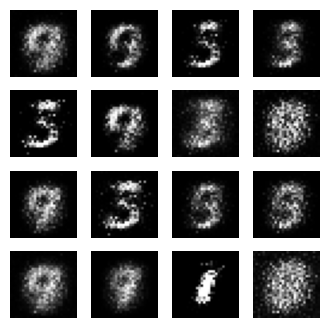

In [6]:
model.display_last_generation_images()